# Analysis of the activity time distribution

The main question is which distribution is most suitable to model the staff activity times (at the table) given the emperical data?

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import scipy.stats as stats
import openturns as ot
from math import ceil

In [2]:
filename = Path('./data/processed/20210818_evening_staff_activities.csv')
df = pd.read_csv(filename, parse_dates=['start_time', 'end_time'])

activity_times = np.array((df['end_time'] - df['start_time'])/np.timedelta64(1, 's'))

### Plot histogram for several bin counts

The plot shows that, regardless of the bin count:
- the visit times range from 2 seconds to 341 seconds
- the bulk is between 2 seconds and 36 seconds 
- the distribution is skewed to the left with a long right tail and depending on the bin count a clear peak around the 6-8 seconds

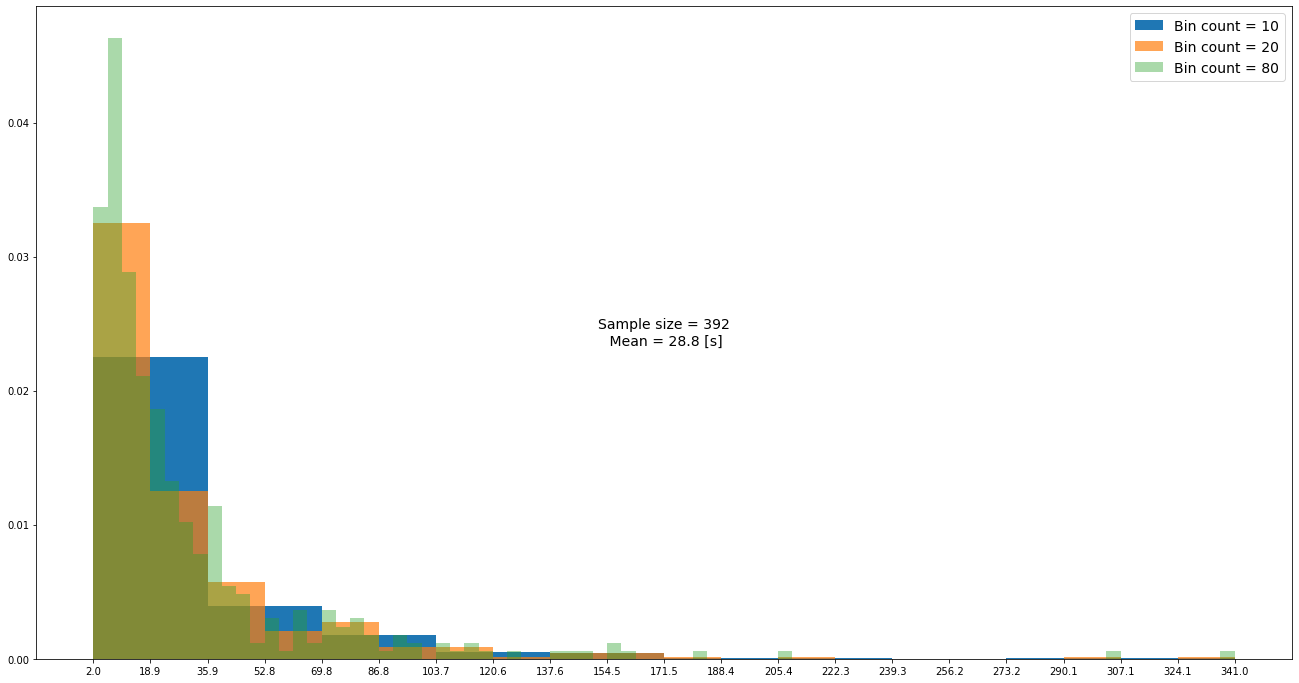

In [3]:
plt.rcParams['figure.figsize'] = [22.5,12]

bin_counts = [10, 20, 80]
alpha_step = 0.6/(len(bin_counts) - 1)
for ii, bin_count in enumerate(bin_counts):
    hist = plt.hist(activity_times, bins=bin_count, density=True, label=f'Bin count = {bin_count}', alpha=1-ii*alpha_step)
    if ii == 1:
        x = hist[1]

plt.xticks(x)
plt.text(0.5,0.5, f'Sample size = {len(activity_times)}\n Mean = {np.mean(activity_times):.1f} [s]', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes, fontsize=14)
leg = plt.legend(fontsize=14)

### Fit the openturns distributions and determine the goodness-of-fit of the different fitted distributions


In [6]:
%%capture --no-stdout

def process_line(line):
    line = line.strip()
    start_ind = 0
    parts = []
    for ii in range(3):
        comma_index = line.find(',', start_ind)
        value = line[start_ind:comma_index].strip()
        if ii == 1 or ii == 2:
            value = float(value)        
        start_ind = comma_index + 1
        parts.append(value)
        
    parts.append(ast.literal_eval(line[start_ind:].strip()))
    return parts

scipy_2_ot_distr = {
    'arcsine': 'ArcsineFactory',
    'beta': 'BetaFactory',
    'burr': 'BurrFactory',
    'chi': 'ChiFactory',
    'chi2': 'ChiSquareFactory',
    'expon': 'ExponentialFactory',
    'invweibull': 'FrechetFactory',
    'gamma': 'GammaFactory',
    'pareto': 'ParetoFactory',
    'genpareto': 'GeneralizedParetoFactory',
    'weibull_max': 'WeibullMaxFactory',
    'genextreme': 'GeneralizedExtremeValueFactory',
    'gumbel_r': 'GumbelFactory',
    'invgauss': 'InverseNormalFactory',
    'laplace': 'LaplaceFactory',
    'logistic': 'LogisticFactory',
    'lognorm': 'LogNormalFactory',
    'loguniform': 'LogUniformFactory',
    'norm': 'NormalFactory',
    'rayleigh': 'RayleighFactory',
    't': 'StudentFactory',
    'trapezoid': 'TrapezoidalFactory',
    'truncnorm': 'TruncatedNormalFactory',
    'uniform': 'UniformFactory',
    'vonmises': 'VonMisesFactory',
    'weibull_min': 'WeibullMinFactory',
}


with open(Path('./data/stats/activitiy_time_fits.txt'), 'r') as f:
    lines = [process_line(line) for line in f if '#' not in line]

min_value = min(activity_times)
max_value = max(activity_times)    

activity_times_ot = ot.Sample(np.expand_dims(activity_times, axis=1))

y, x = np.histogram(activity_times, bins=10, density=True)
bin_size = x[1] - x[0]
x = x[1:] - bin_size

distrs = []
name_length_max = 0
for ii, distr_data in enumerate(lines):
    res = stats.cramervonmises(activity_times, distr_data[0], args=distr_data[3])
    dist = getattr(stats, distr_data[0])(*distr_data[3])
    y_dist = dist.pdf(x)    
    try:
        r, p_pearson = stats.pearsonr(y, y_dist)   
    except:
        r = np.nan
        p_pearson = np.nan
        
    if distr_data[0] in scipy_2_ot_distr:
        factory = getattr(ot, scipy_2_ot_distr[distr_data[0]])
        try:
            ot_dist = factory().build(activity_times_ot)
            res_ot = stats.cramervonmises_2samp(activity_times, np.array(ot_dist.getSample(10000)).flatten())
            ot_cvm_p_val = res_ot.pvalue
            try:
                truncated = ot.TruncatedDistribution(ot_dist, min_value, max_value)
                res_ot = stats.cramervonmises_2samp(activity_times, np.array(truncated.getSample(10000)).flatten())
                ot_trunc_cvm_p_val = res_ot.pvalue
                ot_trunc_dist = truncated      
            except:
                #print(distr_data[0])
                ot_trunc_cvm_p_val = -1
                ot_trunc_dist = None
        except:
            ot_cvm_p_val = -1
            ot_dist = None
            ot_trunc_cvm_p_val = -1
            ot_trunc_dist = None
    else:
        ot_cvm_p_val = -1
        ot_dist = None
        ot_trunc_cvm_p_val = -1
        ot_trunc_dist = None
        
    distrs.append((distr_data[0], distr_data[2], res.pvalue, distr_data[3], r, p_pearson, 
                   ot_cvm_p_val, ot_dist, ot_trunc_cvm_p_val, ot_trunc_dist))
    
    if len(distr_data[0]) > name_length_max:
        name_length_max = len(distr_data[0])

distrs.sort(key=lambda el: (el[8], el[6], el[2]), reverse=True)        
    
#print(f'{"name":>{name_length_max}s} - {"ks":>6s} - {"cvm":>6s} - p - {"pear_r":>6s} - {"pear_p":>6s}')
#for name, ks_p_value, cvm_p_value, params, r, p_pearson in distrs:    
#    print(f'{name:>{name_length_max}s} - {ks_p_value:.4f} - {cvm_p_value:.4f} - {len(params)} - {r:.4f} - {p_pearson:.4f}')

### Plots showing the fit of the distributions, truncated using a minimum an maximum value based on the data

C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(0.72995079).
  warnings.warn(
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:105: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:6893: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:6893: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))


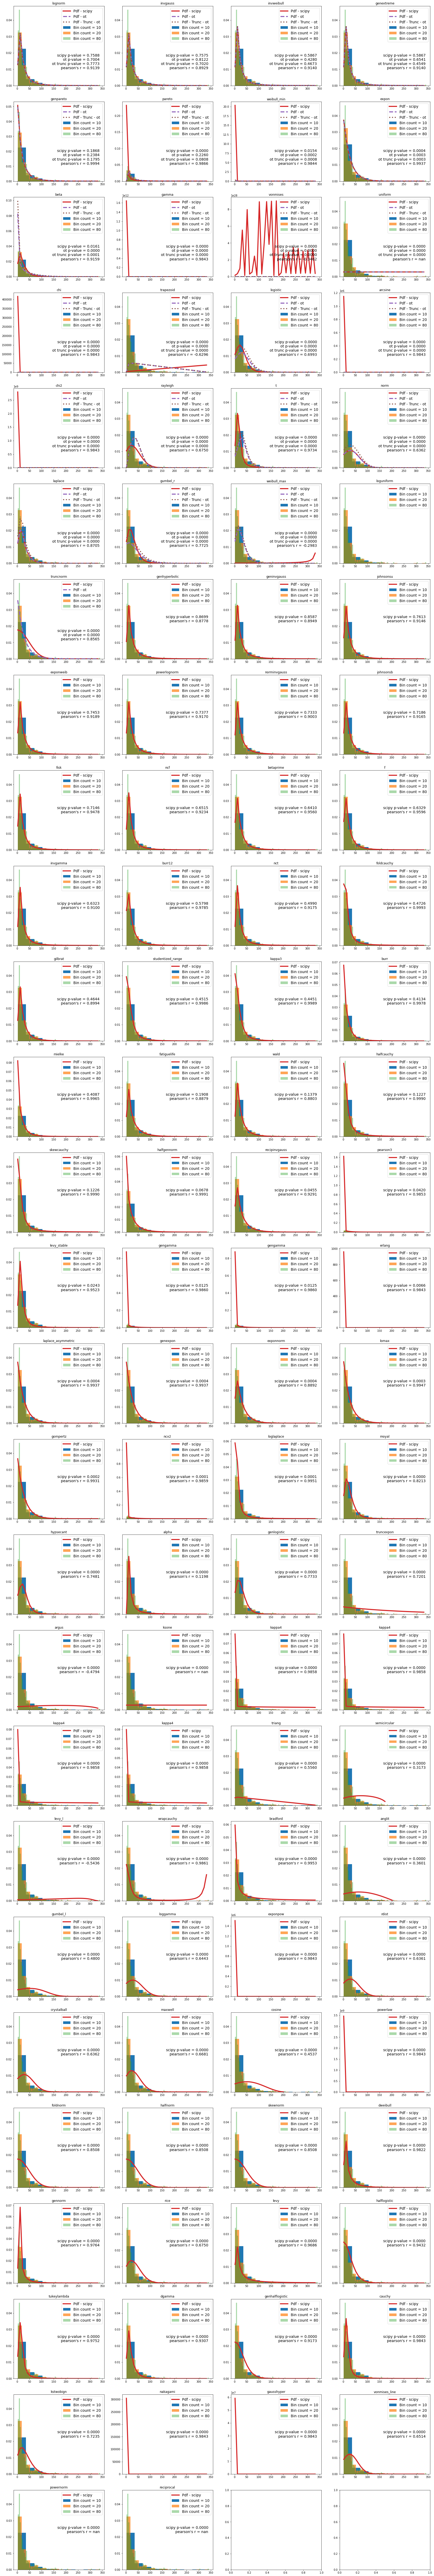

In [7]:
plt.rcParams['figure.figsize'] = [28.5,180]

col_count = 4
row_count = int(ceil(len(lines)/col_count))
_, axes = plt.subplots(row_count, col_count)

axes = axes.flatten()

import scipy.stats as stats

min_value = min(activity_times)
max_value = max(activity_times)

for ii, distr_data in enumerate(distrs):
    name, ks_p_value, cvm_p_value, params, p_r, p_p, ot_cvm_p_val, ot_dist, ot_trunc_cvm_p_val, ot_trunc_dist = distr_data
    for jj, bin_count in enumerate(bin_counts):
        hist = axes[ii].hist(activity_times, bins=bin_count, density=True, label=f'Bin count = {bin_count}', alpha=1-jj*alpha_step)
    
    dist = getattr(stats, name)(*params)
    x = np.arange(max(min_value, dist.ppf(0)), min(max_value,dist.ppf(1)), 10)
    x_ot = ot.Sample(np.expand_dims(x, axis=1))
    axes[ii].plot(x, dist.pdf(x), linewidth=4, label='Pdf - scipy')
    if ot_dist is not None:
        try:
            axes[ii].plot(x, np.array(ot_dist.computePDF(x_ot)), linewidth=4, linestyle='--', label='Pdf - ot')
            if ot_trunc_dist is not None:
                axes[ii].plot(x, np.array(ot_trunc_dist.computePDF(x_ot)), linewidth=4, linestyle=':', label='Pdf - Trunc - ot')
                axes[ii].text(0.95,0.3, f'scipy p-value = {cvm_p_value:.4f}\n ot p-value = {ot_cvm_p_val:.4f}\n ot trunc p-value = {ot_trunc_cvm_p_val:.4f}\n pearson\'s r = {p_r:.4f}', horizontalalignment='right', verticalalignment='center', transform = axes[ii].transAxes, fontsize=14)
            else:
                axes[ii].text(0.95,0.3, f'scipy p-value = {cvm_p_value:.4f}\n ot p-value = {ot_cvm_p_val:.4f}\n pearson\'s r = {p_r:.4f}', horizontalalignment='right', verticalalignment='center', transform = axes[ii].transAxes, fontsize=14)
        except:
            pass
    else:
        axes[ii].text(0.95,0.5, f'scipy p-value = {cvm_p_value:.4f}\n pearson\'s r = {p_r:.4f}', horizontalalignment='right', verticalalignment='center', transform = axes[ii].transAxes, fontsize=14)
    axes[ii].set_title(f'{name}')
    leg = axes[ii].legend(fontsize=14)

### Which distribution to use in the simulations?

1. A truncated distribution should be used both from a realism point of view (negative or zero second durations of activity times are not realistic) and from a practical point of view (the model cannot handle activity times that are smaller than or equal to 0 or very long)
2. The scipy package cannot provide a truncated distribution so for practical reasons a distribution should be chosen which is supported by the openturn package which does support truncated distributions

Based on the p-values the lognoarmal distribution is clearly the best candidate and hence the truncated version would be the most logical choice in the model.
